# Initial setup

In [30]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = "arn:aws:iam::941656036254:role/service-role/AmazonSageMaker-ExecutionRole-20210904T193230"

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/sm-modelparallel-distribution-options'
print('Bucket:\n{}'.format(bucket))

Bucket:
sagemaker-us-east-1-941656036254


In [ ]:
sagemaker.__version__   

In [31]:
data_url = "s3://sagemaker-us-east-1-941656036254/hymenoptera_data"

In [ ]:
bucket

## Train Script



In [ ]:
! pygmentize 1_sources/train_resnet.py

## Debugger Config

In [62]:
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    TensorBoardOutputConfig,
    CollectionConfig,
    rule_configs,
    ProfilerRule
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "2", "eval.save_interval": "1"},
    #collection_configs=[CollectionConfig(
    #    name="custom_collection",
    #    parameters={
    #        "include_regex": ".*weight|.*bias|.*CrossEntropyLoss",
    #        "save_interval": "1",
    #    }
    #)]
)

# Remote Mode

In [83]:

from sagemaker.pytorch import PyTorch

instance_type = 'ml.p2.xlarge'
instance_count = 1
job_name = "pytorch-smdebug-debug-profile-6"

estimator = PyTorch(
          entry_point="train_resnet_sm.py", # Pick your train script
          source_dir='2_sources',
          role=role,
          instance_type=instance_type,
          sagemaker_session=sagemaker_session,
          image_uri="763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.10.2-gpu-py38-cu113-ubuntu20.04-sagemaker",
          instance_count=instance_count,
          hyperparameters={
              "batch-size":64,
              "num-epochs":5,
              "input-size" : 224,
              "num-data-workers" : 8,
              "feature-extract":False,
          },
          disable_profiler=False,
          rules=rules,
          debugger_hook_config=hook_config,
          base_job_name=job_name,
      )

In [84]:
estimator.fit(inputs={"train":f"{data_url}/train", "val":f"{data_url}/val"}, wait=True)

2022-06-12 01:21:28 Starting - Starting the training job...
2022-06-12 01:21:58 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-06-12 01:23:21 Downloading - Downloading input data...
2022-06-12 01:23:59 Training - Downloading the training image.................................
2022-06-12 01:29:34 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-06-12 01:29:26,972 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-06-12 01:29:26,998 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-06-12 01:29:27,006 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-06-12 01:29:27,622 sagemaker-trainin

In [65]:
tensors_path = estimator.latest_job_debugger_artifacts_path()

import smdebug.pytorch as smd
from smdebug import trials
trial = smd.create_trial(tensors_path)

print(f"Saved these tensors: {trial.tensor_names()}")
print(f"Loss values during evaluation were {trial.tensor('CrossEntropyLoss_output_0').values()}")
#print(f"{trial.tensor('relu_input_0').values()}")
# example of plotting values of tensors:
#https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-debugger/model_specific_realtime_analysis/autoencoder_mnist/autoencoder_mnist.html


[2022-06-11 19:36:16.160 C02Y82MBJGH5:2535 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-941656036254/pytorch-smdebug-debug-profile-5-2022-06-10-18-26-06-872/debug-output
Saved these tensors: ['CrossEntropyLoss_output_0', 'gradient/ResNet_bn1.bias', 'gradient/ResNet_bn1.weight', 'gradient/ResNet_conv1.weight', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'gradient/ResNet_layer1.0.bn1.bias', 'gradient/ResNet_layer1.0.bn1.weight', 'gradient/ResNet_layer1.0.bn2.bias', 'gradient/ResNet_layer1.0.bn2.weight', 'gradient/ResNet_layer1.0.conv1.weight', 'gradient/ResNet_layer1.0.conv2.weight', 'gradient/ResNet_layer1.1.bn1.bias', 'gradient/ResNet_layer1.1.bn1.weight', 'gradient/ResNet_layer1.1.bn2.bias', 'gradient/ResNet_layer1.1.bn2.weight', 'gradient/ResNet_layer1.1.conv1.weight', 'gradient/ResNet_layer1.1.conv2.weight', 'gradient/ResNet_layer2.0.bn1.bias', 'gradient/ResNet_layer2.0.bn1.weight', 'gradient/ResNet_layer2.0.bn2.bias', 'gradient/ResNet

## Visualize tensors

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from smdebug import modes

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=modes.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=modes.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


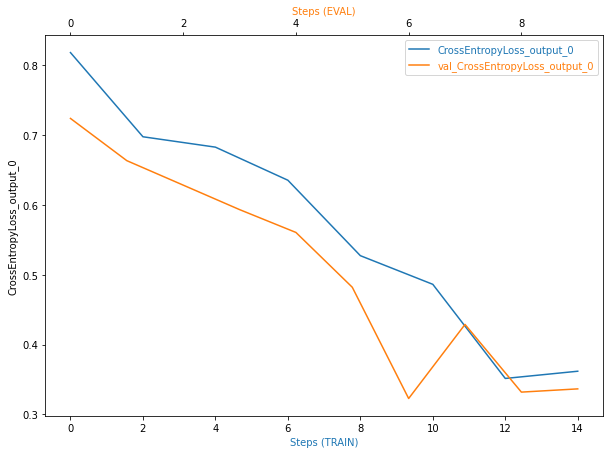

In [67]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

### Rules summary

In [68]:
#estimator.latest_training_job.rule_job_summary()[0]["RuleConfigurationName"])
#estimator.latest_training_job.rule_job_summary()[0]["RuleEvaluationStatus"])
print(estimator.latest_training_job.rule_job_summary()[3])
print(estimator.latest_training_job.rule_job_summary()[0])

for  summary in estimator.latest_training_job.rule_job_summary():
    print(f"Rule: {summary['RuleConfigurationName']}, status: {summary['RuleEvaluationStatus']}")

{'RuleConfigurationName': 'PoorWeightInitialization', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:941656036254:processing-job/pytorch-smdebug-debug-prof-poorweightinitialization-56ca289b', 'RuleEvaluationStatus': 'NoIssuesFound', 'LastModifiedTime': datetime.datetime(2022, 6, 10, 14, 36, 0, 883000, tzinfo=tzlocal())}
{'RuleConfigurationName': 'VanishingGradient', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:941656036254:processing-job/pytorch-smdebug-debug-prof-vanishinggradient-bc55c339', 'RuleEvaluationStatus': 'NoIssuesFound', 'LastModifiedTime': datetime.datetime(2022, 6, 10, 14, 36, 0, 883000, tzinfo=tzlocal())}
Rule: VanishingGradient, status: NoIssuesFound
Rule: Overfit, status: NoIssuesFound
Rule: Overtraining, status: NoIssuesFound
Rule: PoorWeightInitialization, status: NoIssuesFound
Rule: ProfilerReport, status: NoIssuesFound


### Reacting to rules

In [108]:
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    TensorBoardOutputConfig,
    CollectionConfig,
    rule_configs,
    ProfilerRule
)

actions = rule_configs.ActionList(
    rule_configs.StopTraining())


collection_configs=[
        CollectionConfig(
            name="weights",
            parameters={
                "save_histogram": "True"
                }
            ),
        CollectionConfig(name="losses"),
    ]

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient(), actions=actions),
    Rule.sagemaker(rule_configs.overfit(), actions=actions),
    Rule.sagemaker(rule_configs.overtraining(), actions=actions),
    Rule.sagemaker(rule_configs.poor_weight_initialization(), actions=actions),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()) # TODO: need to review different profiler rules https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#profiler-report
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "2", "eval.save_interval": "1"},
    collection_configs=collection_configs
)

In [127]:
import time
from sagemaker.debugger import (ProfilerConfig, 
                                FrameworkProfile, 
                                DetailedProfilingConfig, 
                                DataloaderProfilingConfig, 
                                PythonProfilingConfig,
                                PythonProfiler, cProfileTimer)

profiler_config=ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(
        detailed_profiling_config=DetailedProfilingConfig(
            start_step=2, 
            num_steps=1
        ),
        dataloader_profiling_config=DataloaderProfilingConfig(
            start_step=2, 
            num_steps=1
        ),
        python_profiling_config=PythonProfilingConfig(
            start_step=2, 
            num_steps=1, 
            python_profiler=PythonProfiler.CPROFILE, 
            cprofile_timer=cProfileTimer.TOTAL_TIME
        )
    )
)


In [128]:

from sagemaker.pytorch import PyTorch

instance_type = 'ml.p2.xlarge'
instance_count = 1
job_name = "pytorch-smdebug-early-stop-8"
bucket = sagemaker_session.default_bucket()
tb_debug_path = f"s3://{bucket}/tensorboard/{job_name}"

tensorboard_output_config = TensorBoardOutputConfig(
    s3_output_path=tb_debug_path
)

early_stop_estimator = PyTorch(
          entry_point="train_resnet_sm.py", # Pick your train script
          source_dir='2_sources',
          role=role,
          instance_type=instance_type,
          sagemaker_session=sagemaker_session,
          image_uri="763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.11.0-gpu-py38-cu113-ubuntu20.04-sagemaker",
          instance_count=instance_count,
          hyperparameters={
              "batch-size":64,
              "num-epochs":5,
              "input-size" : 224,
              "num-data-workers" : 8,
              "feature-extract":False,
          },
          disable_profiler=False,
          profiler_config=profiler_config,
          rules=rules,
          debugger_hook_config=hook_config,
          tensorboard_output_config=tensorboard_output_config,
          base_job_name=job_name,
      )

In [129]:
early_stop_estimator.fit(inputs={"train":f"{data_url}/train", "val":f"{data_url}/val"}, wait=True)

2022-06-12 03:07:18 Starting - Starting the training job...
2022-06-12 03:07:44 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-06-12 03:09:19 Downloading - Downloading input data...
2022-06-12 03:09:47 Training - Downloading the training image.................................
2022-06-12 03:15:22 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.8/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
2022-06-12 03:15:18,531 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-06-12 03:15:18,555 sagemaker_pytorch_container.training INFO     Block until all host DNS 

In [130]:
for  summary in early_stop_estimator.latest_training_job.rule_job_summary():
    print(summary)

{'RuleConfigurationName': 'VanishingGradient', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:941656036254:processing-job/pytorch-smdebug-early-stop-vanishinggradient-7a7ab260', 'RuleEvaluationStatus': 'NoIssuesFound', 'LastModifiedTime': datetime.datetime(2022, 6, 11, 23, 18, 43, 719000, tzinfo=tzlocal())}
{'RuleConfigurationName': 'Overfit', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:941656036254:processing-job/pytorch-smdebug-early-stop-overfit-38ccd9e6', 'RuleEvaluationStatus': 'Error', 'StatusDetails': 'InternalServerError: We encountered an internal error. Please try again.', 'LastModifiedTime': datetime.datetime(2022, 6, 11, 23, 18, 43, 719000, tzinfo=tzlocal())}
{'RuleConfigurationName': 'Overtraining', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:941656036254:processing-job/pytorch-smdebug-early-stop-overtraining-5293dc69', 'RuleEvaluationStatus': 'NoIssuesFound', 'LastModifiedTime': datetime.datetime(2022, 6, 11, 23, 18, 43, 719000, tzinfo=tzlocal())}


In [131]:
tb_debug_path

's3://sagemaker-us-east-1-941656036254/tensorboard/pytorch-smdebug-early-stop-8'

In [118]:
## Checking TensorBoard

! tensorboard --logdir  {tb_debug_path}

TensorFlow installation not found - running with reduced feature set.
W0611 22:58:25.761478 4587847168 profile_plugin_loader.py:71] Unable to load profiler plugin. Import error: No module named 'wrapt'
I0611 22:58:26.911773 123145544527872 plugin.py:429] Monitor runs begin
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


# Profiling

In [132]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

training_job_name = early_stop_estimator.latest_training_job.job_name
region = "us-east-1"
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-941656036254/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 2, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 2, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 2, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760'}}
s3 path:s3://sagemaker-us-east-1-941656036254/pytorch-smdebug-early-stop-8-2022-06-12-03-07-15-197/profiler-output


Profiler data from system is available


Also here there are details on how to do it: https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-access-data-profiling-default-plot.html


In [133]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-06-12 00:42:12.577 C02Y82MBJGH5:2535 INFO metrics_reader_base.py:134] Getting 9 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [134]:
framework_metrics_reader = tj.get_framework_metrics_reader()

In [135]:
from smdebug.profiler.analysis.notebook_utils.metrics_histogram import MetricsHistogram

metrics_histogram = MetricsHistogram(system_metrics_reader)
metrics_histogram.plot(
    starttime=0, 
    endtime=system_metrics_reader.get_timestamp_of_latest_available_file(), 
    select_dimensions=["CPU", "GPU", "I/O"], # optional
    select_events=["total"]                  # optional
)

[2022-06-12 00:42:19.139 C02Y82MBJGH5:2535 INFO metrics_reader_base.py:134] Getting 9 event files
Found 16137 system metrics events from timestamp_in_us:0 to timestamp_in_us:1655003820000000
select events:['total']
select dimensions:['CPU', 'GPU', 'I/O']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'I/OWaitPercentage-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'I/OWaitPercentage-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [136]:
#rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path = f"s3://{bucket}/{training_job_name}/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-941656036254/pytorch-smdebug-early-stop-8-2022-06-12-03-07-15-197/rule-output
